## Import Libraries


In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Utilities functions for working with the dataset

In [2]:
def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
        
        
##
## This function reutrn a list of matrices. Each matrix correspond to a question instance in which each row is a channel, and in the coloumn it develop the signal in time
## The function also manage to standardize the time length
def channels_to_vector(channels): 
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


##
# Create the train data matrix
##
## usage
def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


### Description
def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
## description
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix

## EEG feature loading

Import data from previous analysis


In [3]:
#Import data from mat files
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')

channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

#Features Loading
features_extracted_yes   = sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no    = sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes = sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no  = sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']

channels_structure_yes_EEG = channels_to_vector(channels_yes_EEG)
channels_structure_no_EEG  = channels_to_vector(channels_no_EEG)

##Structuring of the data:
#the code below create the train matrix with respect to the signal given in "channel_structure" but using the features contained in "features_extracted*" and in "connettivity_feature*".
feature_dataset_yes_EEG, EEG_yes_labels = get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

feature_dataset_no_EEG, EEG_no_labels = get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);

#Merge the labeled data
feature_dataset_full = np.concatenate((feature_dataset_yes_EEG, feature_dataset_no_EEG), axis=0 )
labels = np.concatenate((EEG_yes_labels,EEG_no_labels), axis=0)


print("The dataset have shape:")
print(feature_dataset_full.shape)

The dataset have shape:
(60, 386)


## Leave One Out 

In [4]:
def leave_one_out(X, Y, classifier):
    svm_total_acc_test = []
    for i in range(X.shape[0]):
#SVM classifier definition
        i1 = [j for j in range(X.shape[0])]
        i1.remove(i)
        i2 = i
        train=X[i1,:]
        labels_train=Y[i1]

        test= X[i2,:]
        labels_test=Y[i2]
        clf_temp = classifier
        clf_temp.fit(train, labels_train)  

        #Accuracy on test
        predicted_labels_test = clf_temp.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))

## Exploration of the best number of features

Only the top-k features that have the best ANOVA F-test Score are retained.
An hard-margin (C=1) SVM linear classifier is trained and its performances assessed with a full search leave-one-out

Might require some computational time (spoiler: best k seems to be 21)

In [5]:
tot_perf = []
for k in range(1,300):
    print('progress: ' + str(k/300*100) + ' %')
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
    svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
    perf_temp = leave_one_out(feature_dataset_reduced, labels, svc)
    tot_perf.append(perf_temp)

best_k = np.argmax(tot_perf)+1
print("smallest k that gives best Leave-one-out results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

progress: 0.33333333333333337 %
progress: 0.6666666666666667 %
progress: 1.0 %
progress: 1.3333333333333335 %


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


progress: 1.6666666666666667 %
progress: 2.0 %
progress: 2.3333333333333335 %
progress: 2.666666666666667 %
progress: 3.0 %
progress: 3.3333333333333335 %
progress: 3.6666666666666665 %
progress: 4.0 %
progress: 4.333333333333334 %
progress: 4.666666666666667 %
progress: 5.0 %
progress: 5.333333333333334 %
progress: 5.666666666666666 %
progress: 6.0 %
progress: 6.333333333333334 %
progress: 6.666666666666667 %
progress: 7.000000000000001 %
progress: 7.333333333333333 %
progress: 7.666666666666666 %
progress: 8.0 %
progress: 8.333333333333332 %
progress: 8.666666666666668 %
progress: 9.0 %
progress: 9.333333333333334 %
progress: 9.666666666666666 %
progress: 10.0 %
progress: 10.333333333333334 %
progress: 10.666666666666668 %
progress: 11.0 %
progress: 11.333333333333332 %
progress: 11.666666666666666 %
progress: 12.0 %
progress: 12.333333333333334 %
progress: 12.666666666666668 %
progress: 13.0 %
progress: 13.333333333333334 %
progress: 13.666666666666666 %
progress: 14.000000000000002

### Print of the results

In [8]:
best_k = np.argmax(tot_perf)+1
print("smallest k that gives best Leave-one-out results:")
print(best_k)
print()
print("wich have lead to the top performance:")
print(np.max(tot_perf))


#What are those features?
reducer = SelectKBest(f_classif, best_k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print()
print("index of features retained:")
print(idx)

smallest k that gives best Leave-one-out results:
21

wich have lead to the top performance:
0.9666666666666667

index of features retained:
[66, 67, 71, 82, 115, 165, 169, 173, 192, 244, 256, 260, 262, 272, 276, 287, 288, 291, 292, 304, 320]


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# Evaluation of performances with varying size train/test

Definition of utilities functions

In [6]:
def classification_SVM_experiments(X, Y, clf_parameters, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        #SVM classificator definition
        C_best = clf_parameters['C']
        gamma_best = clf_parameters['gamma']
        kernel_best = clf_parameters['kernel']
        
        clf = svm.SVC(C = C_best, kernel = kernel_best, gamma = gamma_best, random_state = single_seed)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train

def performance_assesment_fraction(X, Y, num_experiment, clf_parameters):
    fracs = np.linspace(0.2,0.9,25)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments(X, Y, clf_parameters, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    #plot the figure
    plt.figure(figsize=(10, 7), dpi=80)
    plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
    plt.minorticks_on()
    plt.title('SVM perfomances over different train/test dataset of reduced features')
    plt.ylabel('Accuracy')
    plt.xlabel('Train/test fraction')

    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
    plt.show()

Actual calling of the function above

Evaluation progress: 0 %
Evaluation progress: 4 %
Evaluation progress: 8 %
Evaluation progress: 12 %
Evaluation progress: 16 %
Evaluation progress: 20 %
Evaluation progress: 25 %
Evaluation progress: 29 %
Evaluation progress: 33 %
Evaluation progress: 37 %
Evaluation progress: 41 %
Evaluation progress: 45 %
Evaluation progress: 50 %
Evaluation progress: 54 %
Evaluation progress: 58 %
Evaluation progress: 62 %
Evaluation progress: 66 %
Evaluation progress: 70 %
Evaluation progress: 74 %
Evaluation progress: 79 %
Evaluation progress: 83 %
Evaluation progress: 87 %
Evaluation progress: 91 %
Evaluation progress: 95 %
Evaluation progress: 100 %


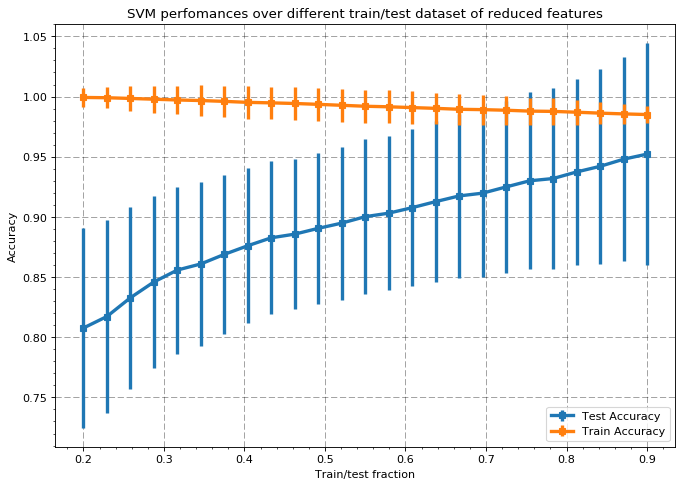

In [7]:
para = {'C' : 1, 'kernel' : 'linear', 'gamma' : 'auto' } #parameters of the SVM

performance_assesment_fraction(feature_dataset_reduced, labels, 5000, para)

## Leave-Two-out evaluation

note: this code could be optimized to be 2 times faster

In [10]:
svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)

X = feature_dataset_reduced
Y = labels

svm_total_acc_test = []
#performances assessment with leave three out
n = X.shape[0]
for i in range(n):
    print("progress: " + str(i/n*100) + " %")
    for j in range(n):
        if(j!=i):
            i1 = [l for l in range(n)]
            i1.remove(i)
            i1.remove(j)
            i2 = [i, j]
                    
            train=X[i1,:]
            labels_train=Y[i1]

            test= X[i2,:]
            labels_test=Y[i2]
 
            clf = svc      
            #SVM fit on train data
            clf.fit(train, labels_train)  

            #Accuracy on test
            predicted_labels_test = clf.predict(test)
            SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
            svm_total_acc_test.append(SVM_accuracy_test)

print()
print()
print("mean of test accuracy")
print(np.mean(svm_total_acc_test))

progress: 0.0 %
progress: 1.6666666666666667 %
progress: 3.3333333333333335 %
progress: 5.0 %
progress: 6.666666666666667 %
progress: 8.333333333333332 %
progress: 10.0 %
progress: 11.666666666666666 %
progress: 13.333333333333334 %
progress: 15.0 %
progress: 16.666666666666664 %
progress: 18.333333333333332 %
progress: 20.0 %
progress: 21.666666666666668 %
progress: 23.333333333333332 %
progress: 25.0 %
progress: 26.666666666666668 %
progress: 28.333333333333332 %
progress: 30.0 %
progress: 31.666666666666664 %
progress: 33.33333333333333 %
progress: 35.0 %
progress: 36.666666666666664 %
progress: 38.333333333333336 %
progress: 40.0 %
progress: 41.66666666666667 %
progress: 43.333333333333336 %
progress: 45.0 %
progress: 46.666666666666664 %
progress: 48.333333333333336 %
progress: 50.0 %
progress: 51.66666666666667 %
progress: 53.333333333333336 %
progress: 55.00000000000001 %
progress: 56.666666666666664 %
progress: 58.333333333333336 %
progress: 60.0 %
progress: 61.66666666666667 %

## Leave-three-out Evaluation

note: this code could be optimized to be 3! = 6 times faster, this will take some time

In [11]:
svc = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)

X = feature_dataset_reduced
Y = labels

svm_total_acc_test = []
#performances assessment with leave three out
n = X.shape[0]
for i in range(n):
    print("progress: " + str(i/n*100) + " %")
    for j in range(n):
        if(j!=i):
            for k in range(n):
                if(k!=j and k!=i):
            #SVM classifier definition
                    i1 = [l for l in range(n)]
                    i1.remove(i)
                    i1.remove(j)
                    i1.remove(k)
                    i2 = [i, j, k]
                    
                    train=X[i1,:]
                    labels_train=Y[i1]

                    test= X[i2,:]
                    labels_test=Y[i2]
                #print(i1)
                #print(i2)
                    clf = svc      
                #SVM fit on train data
                    clf.fit(train, labels_train)  

                #Accuracy on test
                    predicted_labels_test = clf.predict(test)
                    SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
                    svm_total_acc_test.append(SVM_accuracy_test)

print()
print()
print("mean of test accuracy")
print(np.mean(svm_total_acc_test))

progress: 0.0 %
progress: 1.6666666666666667 %
progress: 3.3333333333333335 %
progress: 5.0 %
progress: 6.666666666666667 %
progress: 8.333333333333332 %
progress: 10.0 %
progress: 11.666666666666666 %
progress: 13.333333333333334 %
progress: 15.0 %
progress: 16.666666666666664 %
progress: 18.333333333333332 %
progress: 20.0 %
progress: 21.666666666666668 %
progress: 23.333333333333332 %
progress: 25.0 %
progress: 26.666666666666668 %
progress: 28.333333333333332 %
progress: 30.0 %
progress: 31.666666666666664 %
progress: 33.33333333333333 %
progress: 35.0 %
progress: 36.666666666666664 %
progress: 38.333333333333336 %
progress: 40.0 %
progress: 41.66666666666667 %
progress: 43.333333333333336 %
progress: 45.0 %
progress: 46.666666666666664 %
progress: 48.333333333333336 %
progress: 50.0 %
progress: 51.66666666666667 %
progress: 53.333333333333336 %
progress: 55.00000000000001 %
progress: 56.666666666666664 %
progress: 58.333333333333336 %
progress: 60.0 %
progress: 61.66666666666667 %